In [39]:
import rasterio as rio
from cmr import CollectionQuery, GranuleQuery

import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import ipywidgets as widgets
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
import cartopy.io.img_tiles as cimgt

import requests
import os

# ASO Acqusition

This notebook fetches the ASO catalog and allows for downloading of raw assets. 

In [2]:
# Load the ASO Catalog
nasaAPI = GranuleQuery()
aso = pd.DataFrame(nasaAPI.short_name('ASO_3M_SD').get())
aso.head()

,browse_flag,collection_concept_id,coordinate_system,data_center,dataset_id,day_night_flag,granule_size,id,links,online_access_flag,original_format,polygons,producer_granule_id,time_end,time_start,title,updated
0,False,C1521188702-NSIDC_ECS,GEODETIC,NSIDC_ECS,ASO L4 Lidar Snow Depth 3m UTM Grid V001,UNSPECIFIED,309.929,G1623914151-NSIDC_ECS,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...,True,ECHO10,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,ASO_3M_SD_USCATB_20130403.tif,2013-04-03T23:59:59.000Z,2013-04-03T00:00:00.000Z,SC:ASO_3M_SD.001:162848623,2019-07-09T14:43:15.619Z
1,False,C1521188702-NSIDC_ECS,GEODETIC,NSIDC_ECS,ASO L4 Lidar Snow Depth 3m UTM Grid V001,UNSPECIFIED,1133.05,G1623914238-NSIDC_ECS,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...,True,ECHO10,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,ASO_3M_SD_USCATB_20130429.tif,2013-04-29T23:59:59.000Z,2013-04-29T00:00:00.000Z,SC:ASO_3M_SD.001:162848651,2019-07-09T14:44:30.639Z
2,False,C1521188702-NSIDC_ECS,GEODETIC,NSIDC_ECS,ASO L4 Lidar Snow Depth 3m UTM Grid V001,UNSPECIFIED,1133.05,G1623914198-NSIDC_ECS,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...,True,ECHO10,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,ASO_3M_SD_USCATB_20130503.tif,2013-05-03T23:59:59.000Z,2013-05-03T00:00:00.000Z,SC:ASO_3M_SD.001:162848643,2019-07-09T14:44:00.613Z
3,False,C1521188702-NSIDC_ECS,GEODETIC,NSIDC_ECS,ASO L4 Lidar Snow Depth 3m UTM Grid V001,UNSPECIFIED,1133.05,G1623914214-NSIDC_ECS,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...,True,ECHO10,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,ASO_3M_SD_USCATB_20130525.tif,2013-05-25T23:59:59.000Z,2013-05-25T00:00:00.000Z,SC:ASO_3M_SD.001:162848650,2019-07-09T14:44:15.633Z
4,False,C1521188702-NSIDC_ECS,GEODETIC,NSIDC_ECS,ASO L4 Lidar Snow Depth 3m UTM Grid V001,UNSPECIFIED,1133.05,G1623914150-NSIDC_ECS,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...,True,ECHO10,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,ASO_3M_SD_USCATB_20130601.tif,2013-06-01T23:59:59.000Z,2013-06-01T00:00:00.000Z,SC:ASO_3M_SD.001:162848644,2019-07-09T14:44:00.636Z


In [3]:
# Parse into Useful Data
aso.time_start = pd.to_datetime(aso.time_start)
aso['aso_region'] = [granId.split('_')[3] for granId in aso.producer_granule_id]
polygons = []
for raw_poly in aso.polygons.values:
    t = pd.to_numeric(raw_poly[0][0].split(" "))
    polygons.append(Polygon(list(zip(t[1::2], t[::2]))))
aso['geom'] = polygons

In [4]:
asoRegions = sorted(aso.aso_region.unique())

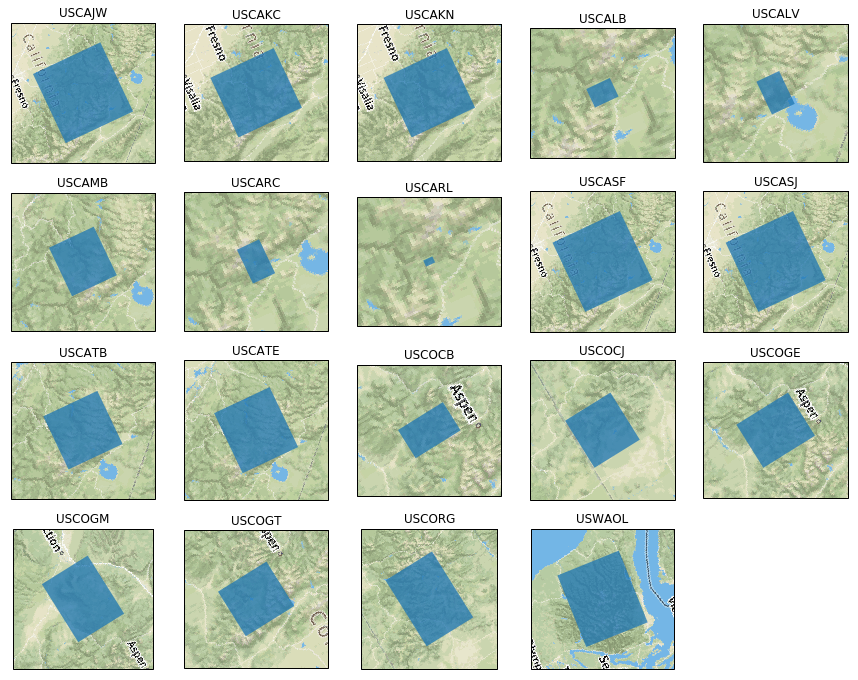

In [10]:
fig = plt.figure(figsize=(15, 15))
gs = plt.GridSpec(5, 5)

mapbox = cimgt.MapboxTiles(
    access_token="pk.eyJ1IjoiYWNhbm5pc3RyYSIsImEiOiJLWVM2RWhJIn0.TputXxRYBUPh-vjDg6_TFA", 
    map_id = 'streets'
)


for i, region in enumerate(asoRegions):
    geom = aso[aso.aso_region == region].geom.values[0]
    _a = plt.subplot(gs[i], projection=ccrs.AlbersEqualArea())
    _a.get_xaxis().set_visible(False)
    _a.get_yaxis().set_visible(False)
    _a.add_geometries([geom], crs=ccrs.PlateCarree(), alpha=0.76)
    _a.set_title(region)
    bds = geom.buffer(0.2).bounds
    _a.set_extent([bds[0], bds[2], bds[1], bds[3]], crs = ccrs.PlateCarree())
    _a.add_image(mapbox, 7)
    

## Set Search Parameters

Choose a region to view ASO Data. 

In [11]:
region = widgets.Dropdown(
    options=asoRegions,
    value=asoRegions[0],
    description='ASO Region:',
    disabled=False,
)
region

Dropdown(description='ASO Region:', options=('USCAJW', 'USCAKC', 'USCAKN', 'USCALB', 'USCALV', 'USCAMB', 'USCA…

## Select Candidates

The above parameters will be used to assess ASO candidates.

In [31]:
regionalCandidates = aso[
    (aso.aso_region == region.value) 
]

In [32]:
granuleSelector = widgets.SelectMultiple(
    options= list(zip(regionalCandidates.time_start, regionalCandidates.producer_granule_id)),
    rows=10,
    description='{}'.format(region.value),
    disabled=False
)
granuleSelector

SelectMultiple(description='USCATE', options=((Timestamp('2016-03-26 00:00:00'), 'ASO_3M_SD_USCATE_20160326.ti…

## Download Data 

In [35]:
urls = [l[0]['href'] for l in regionalCandidates[
    regionalCandidates.producer_granule_id.isin(granuleSelector.value)].links
]

In [41]:
username = ''
password = ''

with requests.Session() as session:
    session.auth = (username, password)
    
    for url in urls:
        response = session.get(url)
        filepath = url.split('/')[-1]
        
        # If the response code is 401, we still need to authorize with earthdata.
        if response.status_code == 401:
            response = session.get(response.url)
        assert response.ok, 'Problem downloading data! Reason: {}'.format(response.reason)

        with open(filepath, 'wb') as f:
            f.write(response.content)

        print(file_name + ' downloaded')


KeyboardInterrupt: 

environ({'CUDA_PATH': '/usr/local/cuda-9.0', 'XDG_SESSION_ID': '1', 'SHELL': '/bin/bash', 'TERM': 'xterm-color', 'SSH_CLIENT': '205.175.106.14 51346 22', 'CONDA_SHLVL': '1', 'LD_PRELOAD': '/usr/lib/libmpi_cxx.so', 'CONDA_PROMPT_MODIFIER': '(pytorch_p36) ', 'SSH_TTY': '/dev/pts/0', 'USER': 'ubuntu', 'LD_LIBRARY_PATH': '/usr/local/cuda-9.0/lib64:/usr/local/cuda-9.0/extras/CUPTI/lib64:/lib/nccl/cuda-9.0/lib:/usr/lib64/openmpi/lib/:/usr/local/lib:/usr/lib:/usr/local/mpi/lib:/lib/:/usr/lib64/openmpi/lib/:/usr/local/lib:/usr/lib:/usr/local/mpi/lib:/lib/:/usr/lib64/openmpi/lib/:/usr/local/lib:/usr/lib:/usr/local/mpi/lib:/lib/:/usr/lib64/openmpi/lib/:/usr/local/lib:/usr/lib:/usr/local/mpi/lib:/lib/:', 'LS_COLORS': 'rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=01;31:*.tgz=01;31:*.arc=01;31:*.arj=01;31:*.taz=01;31:*.lha=01;31:*.lz4=01;31:*.lzh=01;31:*.lzma=01;31:*.tlz=01;31:*